In [1]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx as nx
import time
import matplotlib.pyplot as plt
import pickle
import numpy as np
from seirsplus.utilities import load_model, save_model, convert_percentage_to_scale
# from seirsplus.networks import prune_graph_per_age
plt.rcParams["figure.figsize"] = (12, 6)
import pandas as pd
import os
from scipy.interpolate import interp1d


In [2]:
vacc_data = pd.read_csv("../israel_data/vaccination_data_for_simulation.csv")


In [3]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
folder = 'third_wave_simulation/'

[4, 4, 3, 3, 0, 1, 3, 91, 19, 66, 1.6, array([61.23788546, 57.0969163 , 52.95594714, 48.81497797, 48.81497797,
       57.71806167, 61.85903084, 61.85903084, 66.        , 59.78854626,
       51.50660793, 43.2246696 , 37.01321586, 27.28193833, 19.        ,
       19.        , 91.        ]), 0.07, [0.12, 0.12], 0.9, 123, 1033.1132914041746, 0]
[4, 4, 3, 3, 0, 1, 3, 91, 19, 66, 1.6, array([61.23788546, 57.0969163 , 52.95594714, 48.81497797, 48.81497797,
       57.71806167, 61.85903084, 61.85903084, 66.        , 59.78854626,
       51.50660793, 43.2246696 , 37.01321586, 27.28193833, 19.        ,
       19.        , 91.        ]), 0.07, [0.12, 0.12], 0.9, 536, 1838.0451629689085, 1]
[4, 4, 3, 3, 0, 1, 3, 91, 19, 66, 1.6, array([61.23788546, 57.0969163 , 52.95594714, 48.81497797, 48.81497797,
       57.71806167, 61.85903084, 61.85903084, 66.        , 59.78854626,
       51.50660793, 43.2246696 , 37.01321586, 27.28193833, 19.        ,
       19.        , 91.        ]), 0.07, [0.12, 0.12], 0.9,

<ipython-input-176-75a734c33d95>:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)


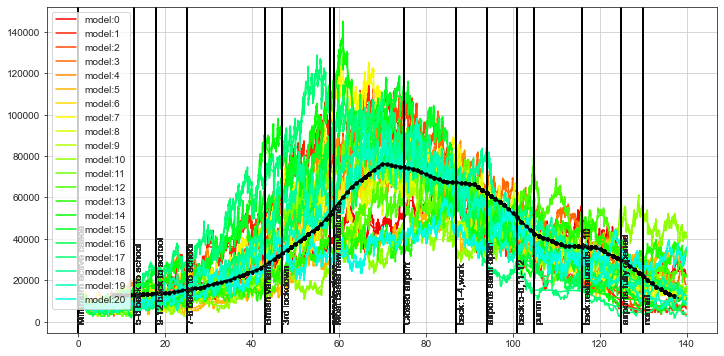

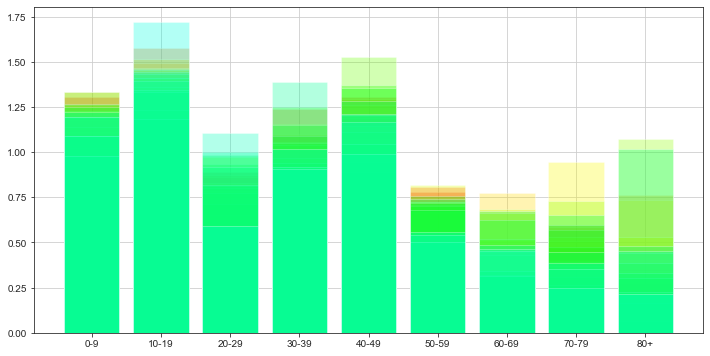

<Figure size 864x432 with 0 Axes>

In [176]:
# N = 10000
i_color = 0
directory ='third_wave_simulation/choose_best' +("/")+'2021_04_14'
files_name = os.listdir(directory)
colors = get_cmap(len(files_name))
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = numpy.load(f'{folder}/time_3rd_wave.npy')
active_cases = numpy.load(f'{folder}/active_cases_3rd_wave.npy')



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 
                 'holiday', 'quarantine_per', 'normal', 'max_value','R0_factor','percentage_out',
                'q_global_adults', 'q_global_kids', 'percentage_edges_removed_vacc', 'seed']
# relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 
#                  'holiday', 'quarantine_per', 'normal', 'max_value','R0_factor','percentage_out',
#                ]
plt.figure()

for i in range(int(len(files_name)/2)):
    max_time = 140
    min_time = 8
    
    config_name = "input_config"+str(i)
    path_name_config = f"{directory}/{config_name}"
    
    model_name = "model"+str(i)
    path_name_model = f"{directory}/{model_name}"
    
    with open(f"{path_name_config}.pickle", 'rb') as handle:
        config_load=  pickle.load(handle)
        
    
    with open(f"{path_name_model}.pickle", 'rb') as handle:
        model_load=  pickle.load(handle)
    
    
    relevant_input = [config_load[k] for k in relevant_keys]
    N = config_load['N']
    
    data['model'].append(model_load)
    data['input_config'].append(config_load)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
     
    model_data = (((data['model'][i].numI_sym+data['model'][i].numH)*9e6)/N)[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))

    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = np.max([min_time, smooth_time.min()+1])
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time+7, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_to_plot, model_data, color=colors[i_color], label=f'model:{i}')
    ax.plot(time_scale, model_out, color=colors[i_color])
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
    ax.plot(time_scale, real_data, '-k', marker='.')
    model_diff = np.linalg.norm((model_out - real_data)/time_scale.size)
    relevant_input.append(model_diff)
    relevant_input.append(i)
    print(relevant_input)

    #                   [0-9,  10-19,20-29,30-39,40-49,50-59,60-69,70-79, 80+]
    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i_color], alpha=0.3)
#     relevant_input.append(np.array(y_m))
    data['relevant_data'].append(relevant_input)
    i_color += 1
ax.legend()
relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

In [177]:
for c in input_df.columns:
    if c != "folder_num" or c!="percentage_out":
        try:
            input_df[c] = input_df[c].astype(float)
        except:
            print("")

input_df.sort_values(by="model_diff")


,airport,two_grades,pre_school,restaurants,work,starting_prec,holiday,quarantine_per,normal,max_value,R0_factor,percentage_out,q_global_adults,q_global_kids,percentage_edges_removed_vacc,seed,model_diff,folder_num
8,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,464.0,543.243070,8.0
3,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,807.0,647.470070,3.0
19,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,797.0,704.601306,19.0
6,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,775.0,751.513489,6.0
18,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,975.0,922.851237,18.0
9,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,83.0,939.301877,9.0
4,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,428.0,970.976786,4.0
12,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,396.0,981.132028,12.0
16,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,828.0,1000.981936,16.0
11,4.0,4.0,3.0,3.0,0.0,1.0,3.0,91.0,19.0,66.0,1.6,"[61.23788546255507, 57.096916299559474, 52.955...",0.07,"[0.12, 0.12]",0.9,386.0,1021.637844,11.0


In [122]:
# input_df.iloc[5,input_df.columns=='percentage_out'].values[0]

In [123]:
# [(k,data['input_config'][23][k]) for k in data['input_config'][23].keys() if k not in ['beta_values', 'beta_q_values','Q_GLOBALINTXN','P_GLOBALINTXN', 'checkpoint_times']]

In [174]:
for i in range(len(data['model'])):
    try:
        n_i = [(a,np.where(data['model'][i].Xseries[0, data['model'][i].nodeGroupData[a]['nodes']] == 2)[0]) for a in data['model'][i].nodeGroupData.keys()]
        print(f"\t run:{i} , {n_i}")
    except:
        "no x series"


	 run:0 , [('0-9', array([  61,  908, 1194])), ('10-19', array([782])), ('20-29', array([663])), ('30-39', array([], dtype=int64)), ('40-49', array([ 516, 1071])), ('50-59', array([], dtype=int64)), ('60-69', array([], dtype=int64)), ('70-79', array([], dtype=int64)), ('80+', array([], dtype=int64))]
	 run:1 , [('0-9', array([332, 861])), ('10-19', array([], dtype=int64)), ('20-29', array([], dtype=int64)), ('30-39', array([18])), ('40-49', array([120])), ('50-59', array([184, 532])), ('60-69', array([], dtype=int64)), ('70-79', array([277])), ('80+', array([], dtype=int64))]
	 run:2 , [('0-9', array([534])), ('10-19', array([], dtype=int64)), ('20-29', array([678])), ('30-39', array([428, 566])), ('40-49', array([1192])), ('50-59', array([673])), ('60-69', array([], dtype=int64)), ('70-79', array([356])), ('80+', array([], dtype=int64))]
	 run:3 , [('0-9', array([ 206, 1199, 1448])), ('10-19', array([], dtype=int64)), ('20-29', array([141, 144])), ('30-39', array([], dtype=int64)), ('

In [131]:
[data['model'][i].G.degree[351] for i in range(5)]

[12, 6, 9, 8, 8]

In [193]:
np.sum(data['model'][0].positive), np.sum(data['model'][0].X == 7)

(1145, 3756)

In [192]:
data['input_config'][8]

{'N': 10000,
 'airport': 4,
 'two_grades': 4,
 'pre_school': 3,
 'restaurants': 3,
 'work': 0,
 'starting_prec': 1,
 'holiday': 3,
 'quarantine_per': 91,
 'normal': 19,
 'max_value': 66,
 'percentage_out': array([61.23788546, 57.0969163 , 52.95594714, 48.81497797, 48.81497797,
        57.71806167, 61.85903084, 61.85903084, 66.        , 59.78854626,
        51.50660793, 43.2246696 , 37.01321586, 27.28193833, 19.        ,
        19.        , 91.        ]),
 'p_global_kids': 0.09,
 'p_global_adults': 0.15,
 'q_global_kids': [0.12, 0.12],
 'q_global_adults': 0.07,
 'seed': 464,
 'percentage_edges_removed_vacc': 0.9,
 'R0_factor': 1.6}

In [ ]:
# self.S = 1
# self.E = 2
# self.I_pre = 3
# self.I_sym = 4
# self.I_asym = 5
# self.H = 6
# self.R = 7
# self.F = 8
# self.Q_S = 11
# self.Q_E = 12
# self.Q_pre = 13
# self.Q_sym = 14
# self.Q_asym = 15
# self.Q_R = 17

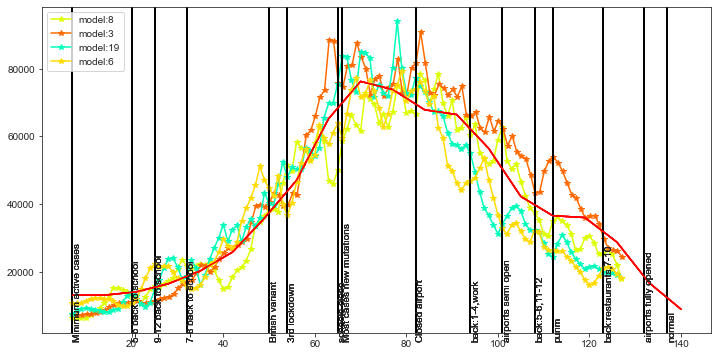

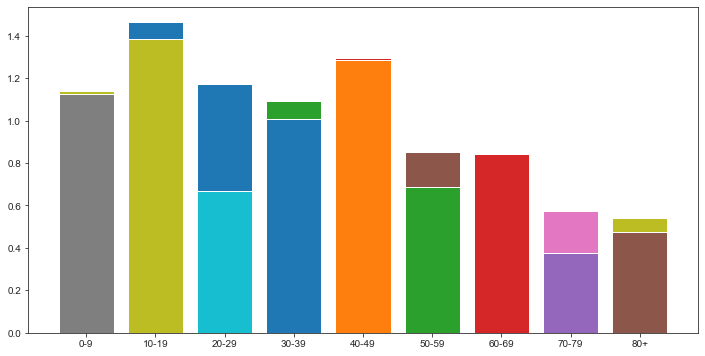

In [179]:
# time_line = [5, 30, 60, 90, 115, 120, 137, 150, 160]
# events = ['hofesh gadol', 'close <50,20', 'close work', 'schools back', 'full seger', 'maximum-72k',
#          'kindergarden back', 'grades 1-4 back', 'minimum-8000']
m_to_plot = [8, 3, 19, 6]
real_factors = []
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)

for m in m_to_plot: 
    max_time = 130
    min_time = 7
    model_2 = data["model"][m]
#     print(input_df.iloc()[13, :])
    N = 10000
    times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
    event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']
    time_ind = np.where(model_2.tseries<=max_time)[0]
    
    
    model_data = (((model_2.numI_sym+model_2.numH)*9e6)/N)[time_ind]
    time_to_plot = model_2.tseries[time_ind]
    
    smooth_model = moving_average(model_data, np.ceil(model_2.numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(model_2.numI_sym.shape[0] / 100).astype(int))
    
    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = np.max([min_time, smooth_time.min()+1])
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time+7, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[m], label=f'model:{m}', marker='*')
    
#     plt.plot(model_2.tseries, ((model_2.numI_sym+model_2.numH)*9e6)/N)
    for time, event in zip(times_for_sim, event):
        ax.axvline(int(time) + 7, 0, 1, c='k')
        ax.text(int(time)+0.1 + 7, 0, str(event), rotation=90)

    time = numpy.load('third_wave_simulation/time_3rd_wave.npy')
    active_casese = numpy.load('third_wave_simulation/active_cases_3rd_wave.npy')
    ax.plot(time + 7, active_casese, '-r')

    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    for num, key in enumerate(model_2.nodeGroupData.keys()):
        mean_age = np.mean(model_2.nodeGroupData[key]['numPositive']/(model_2.numPositive+1e-5))
        ax1.bar(key,(mean_age/age_dist[num]).astype(float))

#     fig, ax = model_2.figure_infections(combine_Q_infected=False)
#     plt.show()
#     model_2.numE /model_2.numI_sym
ax.legend()

In [ ]:
max_time = 130
names = ['model_y2o', 'model_no_vacc', 'model_triangle']
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
colors = get_cmap(10)
for i_n, n in enumerate(names):
    model_2 = load_model(f"third_wave_simulation/vacc_policy/2021_04_13/{n}")
    N = 10000
    times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
    event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']
    time_ind = np.where(model_2.tseries<=max_time)[0]


    model_data = (((model_2.numI_sym+model_2.numH)*9e6)/N)[time_ind]
    time_to_plot = model_2.tseries[time_ind]

    smooth_model = moving_average(model_data, np.ceil(model_2.numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(model_2.numI_sym.shape[0] / 100).astype(int))

    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = smooth_time.min()+1
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[i_n], label=f'model:{n}')

    #     plt.plot(model_2.tseries, ((model_2.numI_sym+model_2.numH)*9e6)/N)
    for time, event in zip(times_for_sim, event):
        ax.axvline(int(time), 0, 1, c='k')
        ax.text(int(time)+0.1, 0, str(event), rotation=90)

    time = numpy.load('third_wave_simulation/time_3rd_wave.npy')
    active_casese = numpy.load('third_wave_simulation/active_cases_3rd_wave.npy')
    ax.plot(time, active_casese, '-r')

    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    for num, key in enumerate(model_2.nodeGroupData.keys()):
        mean_age = np.mean(model_2.nodeGroupData[key]['numPositive']/(model_2.numPositive+1e-5))
        ax1.bar(key,(mean_age/age_dist[num]).astype(float), color=colors[i_n], alpha=0.5)

#     fig, ax = model_2.figure_infections(combine_Q_infected=False)
#     plt.show()
ax.legend()

In [ ]:
N = 10000
colors = get_cmap(30)
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = numpy.load('g_third_lockdown/time_3rd_wave.npy')
active_cases = numpy.load('g_third_lockdown/active_cases_3rd_wave.npy')



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_alpha") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 'holiday', 'quarantine_per', 'normal','percentage_out']
plt.figure()
for i, s in enumerate(subfolders):
    max_time = 130
    data['model'].append(load_model(f"{s}/model_out"))
    with open(f"{s}/input_config.pickle", 'rb') as handle:
        input_data = pickle.load(handle)
    relevant_input = [input_data[k] for k in relevant_keys]
    data['input_config'].append(input_data)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
    
    model_data = (((data['model'][i].numI_sym+data['model'][i].numH)*9e6)/N)[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    
    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = smooth_time.min()+1
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[i], label=f'model:{i}')
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
    ax.plot(time_scale, real_data, '-k', marker='.')
    model_diff = np.linalg.norm((model_out - real_data)/time_to_plot.size)
    relevant_input.append(model_diff)
    relevant_input.append(s)
    data['relevant_data'].append(relevant_input)
    #                   [0-9,  10-19,20-29,30-39,40-49,50-59,60-69,70-79, 80+]
    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i], alpha=0.3)
ax.legend()
relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

In [ ]:
alone_parma = 0.3
couples_without_kids_param = 0.85
kids_left_house_p = 0.36
old_kids = 0.3
two_kids_young = 0.28
two_kids_old = 0.032

three_kids_young = 0.37
three_kids_old = 0.1

four_kids_young = 0.37
four_kids_old = 0.1

number_of_people_each_household = [1, 4, 4, 2, 2, 3, 3, 4, 5, 8]
households_data = \
    {
    'alone': {0.05 * 0.9: [0, 0, alone_parma/2, alone_parma/2, 0, 0 * (1 - alone_parma) / 8,3 * (1 - alone_parma) / 8,2 * (1 - alone_parma) / 8, 3 * (1 - alone_parma) / 8]},
    'students_app': {0.05 * 0.1: [0, 0.2, 0.8, 0, 0, 0, 0, 0, 0]},
    'soldier': {0.015: [0.0, 0.8, 0.2, 0, 0, 0, 0, 0, 0]},
    'couples_without_kids': {0.935 * 0.28 * 0.25: [0, 0, couples_without_kids_param, 1 - couples_without_kids_param, 0, 0, 0, 0, 0]},
    'couples_kids_left_the_house': {0.935 * 0.28 * 0.75: [0, 0, 0, 0, 0, kids_left_house_p, 16 * (1 - kids_left_house_p) / 30,10 * (1 - kids_left_house_p) / 30, 4 * (1 - kids_left_house_p) / 30]},
    'couples_with_one_young_kid': {0.935 * 0.18 * 0.9: [0.7, 0.3, 0.5, 0.5, 0, 0, 0, 0, 0]},
    'couples_with_one_old_kid': {0.935 * 0.18 * 0.1: [0.0, 1.0, 0.0, old_kids, 1 - old_kids, 0, 0, 0, 0]},
    'couples_with_two_kid': {0.935 * 0.19: [0.5, 0.45, 0.05, two_kids_young, 1 - two_kids_young - two_kids_old, two_kids_old, 0, 0, 0]},
    'couples_with_three_kid': {0.935 * 0.17: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young, three_kids_old, 0,0, 0]},
    'couples_with_four_kid_pluse': {0.935 * 0.18: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young, three_kids_old, 0,0, 0]},
}
households_data

In [ ]:
data_pol